### Part f): Classification  analysis using neural networks

With a well-written code it should now be easy to change the
activation function for the output layer.

Here we will change the cost function for our neural network code
developed in parts b), d) and e) in order to perform a classification
analysis.  The classification problem we will study is the multiclass
MNIST problem, see the description of the full data set at
<https://www.kaggle.com/datasets/hojjatk/mnist-dataset>. We will use the Softmax cross entropy function discussed in a). 
The MNIST data set discussed in the lecture notes from week 42 is a downscaled variant of the full dataset. 

Feel free to suggest other data sets. If you find the classic MNIST data set somewhat limited, feel free to try the  
MNIST-Fashion data set at for example <https://www.kaggle.com/datasets/zalando-research/fashionmnist>.

To set up the data set, the following python programs may be useful

To measure the performance of our classification problem we will use the
so-called *accuracy* score.  The accuracy is as you would expect just
the number of correctly guessed targets $t_i$ divided by the total
number of targets, that is

$$
\text{Accuracy} = \frac{\sum_{i=1}^n I(t_i = y_i)}{n} ,
$$

where $I$ is the indicator function, $1$ if $t_i = y_i$ and $0$
otherwise if we have a binary classification problem. Here $t_i$
represents the target and $y_i$ the outputs of your FFNN code and $n$ is simply the number of targets $t_i$.

Discuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter $\lambda$, various activation functions, number of hidden layers and nodes and activation functions.  

### Library imports

In [19]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


from Implementations.activations import relu, relu_deriv, linear, linear_deriv
from Implementations.losses import cross_entropy_with_logits, cross_entropy_with_logits_deriv
from Implementations.optimizers import Adam
from Implementations.neural_network import NeuralNetwork
seed = 6114

### Plot styling

In [32]:
from cycler import cycler
import matplotlib

# ---------- Updated palette with clearer separation ----------
economist_palette = [
    "#E3120B",  # strong red
    "#0096FF",  # bright blue
    "#FFC107",  # yellow
    "#007A3D",  # green
    "#FF6F00",  # orange
    "#6E6E6E",  # medium gray
    "#6A1B9A",  # purple
    "#40C4FF",  # light sky blue
    "#005566",  # deep teal
    "#A10000",  # dark red
]

matplotlib.rcParams.update({
    # ----------- Font & text -----------
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "font.size": 22,
    "axes.labelsize": 18,
    "axes.titlesize": 26,          # large titles (good after LaTeX shrink)
    "axes.titleweight": "bold",
    "axes.titlelocation": "center",
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,

    # ----------- Figure quality --------
    "figure.figsize": (12, 8),      # safe even when LaTeX squeezes to 1 column
    "figure.dpi": 300,
    "savefig.dpi": 450,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,

    # ----------- Line style ------------
    "lines.linewidth": 3.0,
    "lines.markersize": 8,

    # ----------- Grid & axes -----------
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.8,
    "grid.alpha": 0.40,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "figure.facecolor": "white",
    "axes.facecolor": "white",

    # ----------- Ticks -----------------
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,

    # ----------- Legend ----------------
    "legend.frameon": False,

    # ----------- Color cycle -----------
    "axes.prop_cycle": cycler(color=economist_palette),
})


In [20]:
def accuracy_from_logits(logits, y_true):
    preds = np.argmax(logits, axis=1)
    labels = np.argmax(y_true, axis=1)
    return np.mean(preds == labels)

In [21]:
transform = transforms.Compose([
    transforms.ToTensor()
])

fashion_train = datasets.FashionMNIST(root="./data", train=True, download=True,transform=transform)
fashion_test = datasets.FashionMNIST(root="./data", train=False, download=True,transform=transform)

X_train = fashion_train.data.numpy().astype(np.float64) / 255.0
X_test = fashion_test.data.numpy().astype(np.float64) / 255.0

y_train = fashion_train.targets.numpy().astype(np.int64)
y_test = fashion_test.targets.numpy().astype(np.int64) 

X_train = X_train.reshape(-1, 28*28) #images are 28*28 pixels
X_test = X_test.reshape(-1, 28*28)

# One hot encoding 
Y_train = np.zeros((y_train.size, 10))
Y_train[np.arange(y_train.size), y_train] = 1.0

Y_test = np.zeros((y_test.size, 10))
Y_test[np.arange(y_test.size), y_test] = 1.0


In [22]:
layer_sizes = [128, 64, 10]
activation_funcs = [relu, relu, linear]
activation_ders  = [relu_deriv, relu_deriv, linear_deriv]

net = NeuralNetwork(
    network_input_size=X_train.shape[1],
    layer_output_sizes=layer_sizes,
    activation_funcs=activation_funcs,
    activation_ders=activation_ders,
    cost_fun=cross_entropy_with_logits,
    cost_der=cross_entropy_with_logits_deriv,
    seed=seed,
    l2_lambda=1e-4
)

optimizer = Adam(lr=5e-4)
epochs = 500

history = {"train_loss" : [], "train_acc": [], "test_acc": []}

for epoch in range(1,epochs+1):
    net.fit(X_train, Y_train, epochs=1, batch_size=128, optimizer=optimizer, shuffle=True, log_every=None)

    train_loss = net.cost(X_train, Y_train)
    history["train_loss"].append(train_loss)

    train_acc = accuracy_from_logits(net.predict(X_train),Y_train)
    test_acc = accuracy_from_logits(net.predict(X_test),Y_test)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)


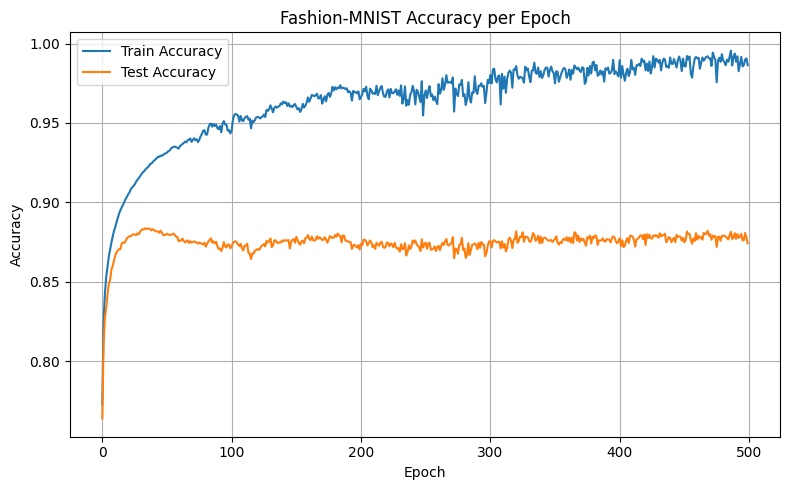

In [23]:
plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["test_acc"],  label="Test Accuracy")
plt.title("Fashion-MNIST Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import random

random.seed(seed)
np.random.random(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

def accuracy_from_logits_torch(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.from_numpy(X_train).float().to(device)
Y_train_t = torch.from_numpy(Y_train).float().to(device)
X_test_t = torch.from_numpy(X_test).float().to(device)
Y_test_f = torch.from_numpy(Y_test).float().to(device)

y_train_labels = torch.from_numpy(np.argmax(Y_train, axis=1)).long().to(device)
y_test_labels  = torch.from_numpy(np.argmax(Y_test, axis=1)).long().to(device)

class NeuralNetworkTorch(nn.Module):
    def __init__(self, input_dim, h1, h2, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

in_features = X_train.shape[1]
layer_sizes = [128, 64, 10]

net_torch = NeuralNetworkTorch(in_features, layer_sizes[0], layer_sizes[1],layer_sizes[2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_torch.parameters(), lr=5e-4, weight_decay=1e-4)

epochs = 500
batch_size = 128

history_torch = {"train_loss": [], "train_acc": [], "test_acc": []}

n = X_train_t.size(0)
for epoch in range(1, epochs + 1): 
    net_torch.train()
    perm = torch.randperm(n)
    for i in range(0, n, batch_size):
        idx = perm[i:i+batch_size]
        xb = X_train_t[idx]
        yb = y_train_labels[idx]

        optimizer.zero_grad()
        logits = net_torch(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
    
    net_torch.eval()
    with torch.no_grad():
        train_logits = net_torch(X_train_t)
        train_loss = criterion(train_logits, y_train_labels).item()
        train_acc = accuracy_from_logits_torch(train_logits, y_train_labels)

        test_logits = net_torch(X_test_t)
        test_acc = accuracy_from_logits_torch(test_logits, y_test_labels)

    history_torch["train_loss"].append(train_loss)
    history_torch["train_acc"].append(train_acc)
    history_torch["test_acc"].append(test_acc)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, train loss {train_loss:.4f}, train acc {train_acc:.4f}, test acc {test_acc:.4f}")


Epoch: 50, train loss 0.1358, train acc 0.9511, test acc 0.8891
Epoch: 100, train loss 0.0770, train acc 0.9722, test acc 0.8868
Epoch: 150, train loss 0.0337, train acc 0.9908, test acc 0.8879
Epoch: 200, train loss 0.0303, train acc 0.9901, test acc 0.8904
Epoch: 250, train loss 0.0549, train acc 0.9796, test acc 0.8852
Epoch: 300, train loss 0.0270, train acc 0.9918, test acc 0.8897
Epoch: 350, train loss 0.0348, train acc 0.9882, test acc 0.8881
Epoch: 400, train loss 0.0233, train acc 0.9937, test acc 0.8820
Epoch: 450, train loss 0.0140, train acc 0.9974, test acc 0.8897
Epoch: 500, train loss 0.0193, train acc 0.9946, test acc 0.8871


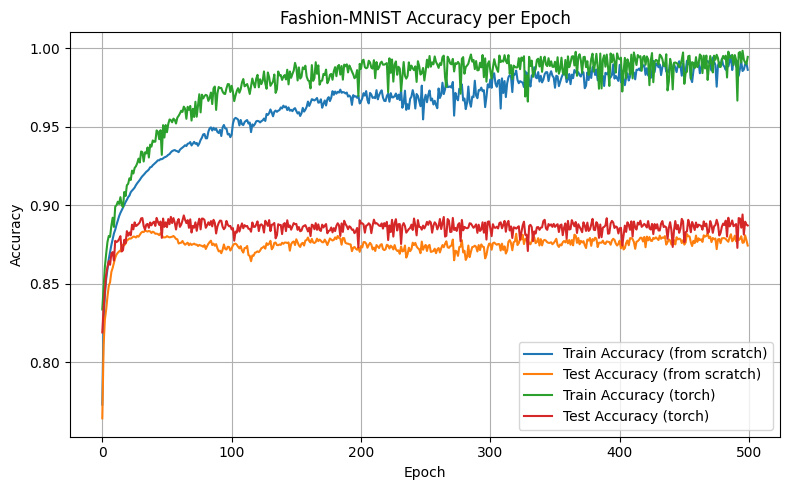

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy (from scratch)")
plt.plot(history["test_acc"],  label="Test Accuracy (from scratch)")
plt.plot(history_torch["train_acc"], label="Train Accuracy (torch)")
plt.plot(history_torch["test_acc"],  label="Test Accuracy (torch)")
plt.title("Fashion-MNIST Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Testing parameters:

### **Pyramidal layer width schedule**

To ensure a pyramidal network structure, we define the number of neurons in each hidden layer \(k\) as a geometrically decaying sequence:

$$
w_k = \max\!\left( \left\lceil W_1 \, r^{\,k-1} \right\rceil, \, w_{\min} \right),
\quad k = 1, 2, \dots, D
$$

where  

- \( W_1 \) is the width of the first hidden layer,  
- \( r \in (0,1) \) is the decay factor (e.g. \( r = 0.5 \)),  
- \( w_{\min} \) is the minimum allowed number of neurons (to prevent the width from dropping below 10),  
- \( D \) is the total number of hidden layers.  

The final output layer contains 10 neurons:

$$
w_{D+1} = 10
$$

As an example, for \( W_1 = 256 \), \( r = 0.5 \), and \( D = 3 \), the resulting hidden-layer widths are:

$$
[w_1, w_2, w_3, w_4] = [256,\, 128,\, 64,\, 10]
$$

In [26]:
def make_pyramid_widths(W1, D, r=0.5, min_hidden=12):
    ws = []
    prev = None
    for k in range(D):
        w = max(int(np.ceil(W1 * (r ** k))), min_hidden)
        if prev is not None:
            w = min(w, prev)             
            w = max(w, min_hidden)
        ws.append(w)
        prev = w
    return ws  # e.g., [256,128,b64] for D=3, W1=256

make_pyramid_widths(64,10)

[64, 32, 16, 12, 12, 12, 12, 12, 12, 12]

In [27]:
depth_list = [1,2,3,4]
width_list = [64, 128, 256, 512]
decay = 0.5
epochs = 60
batch_size = 128
lr = 5e-4
l2 = 1e-4
seed = 6114

def run_model(hidden_list):
    layer_sizes = hidden_list + [10]
    net = NeuralNetwork(
        network_input_size = X_train.shape[1],
        layer_output_sizes = layer_sizes, 
        activation_funcs = [relu]*len(hidden_list) + [linear],
        activation_ders = [relu_deriv]*len(hidden_list) + [linear_deriv],
        cost_fun = cross_entropy_with_logits, 
        cost_der = cross_entropy_with_logits_deriv,
        seed = seed,
        l2_lambda = l2
    )

    opt = Adam(lr=lr)
    net.fit(X_train, Y_train, epochs, batch_size, opt, shuffle=True, log_every=None)

    logits_test = net.predict(X_test)
    preds = np.argmax(logits_test, axis=1)
    labels = np.argmax(Y_test, axis=1)
    acc = (preds == labels).mean()
    return acc

In [28]:
H = np.zeros((len(depth_list),len(width_list)),dtype=float)

for i, D in enumerate(depth_list):
    for j, W1 in enumerate(width_list):
        hidden = make_pyramid_widths(W1, D, r=decay, min_hidden=12)
        acc = run_model(hidden)
        H[i,j] = acc
        print(f"D={D}, W1={W1}, hidden: {hidden},  test_acc: {acc:.4f}")

D=1, W1=64, hidden: [64],  test_acc: 0.8791
D=1, W1=128, hidden: [128],  test_acc: 0.8898
D=1, W1=256, hidden: [256],  test_acc: 0.8954
D=1, W1=512, hidden: [512],  test_acc: 0.8980
D=2, W1=64, hidden: [64, 32],  test_acc: 0.8779
D=2, W1=128, hidden: [128, 64],  test_acc: 0.8839
D=2, W1=256, hidden: [256, 128],  test_acc: 0.8890
D=2, W1=512, hidden: [512, 256],  test_acc: 0.8862
D=3, W1=64, hidden: [64, 32, 16],  test_acc: 0.8668
D=3, W1=128, hidden: [128, 64, 32],  test_acc: 0.8826
D=3, W1=256, hidden: [256, 128, 64],  test_acc: 0.8871
D=3, W1=512, hidden: [512, 256, 128],  test_acc: 0.8824
D=4, W1=64, hidden: [64, 32, 16, 12],  test_acc: 0.8335
D=4, W1=128, hidden: [128, 64, 32, 16],  test_acc: 0.8634
D=4, W1=256, hidden: [256, 128, 64, 32],  test_acc: 0.8834
D=4, W1=512, hidden: [512, 256, 128, 64],  test_acc: 0.8795


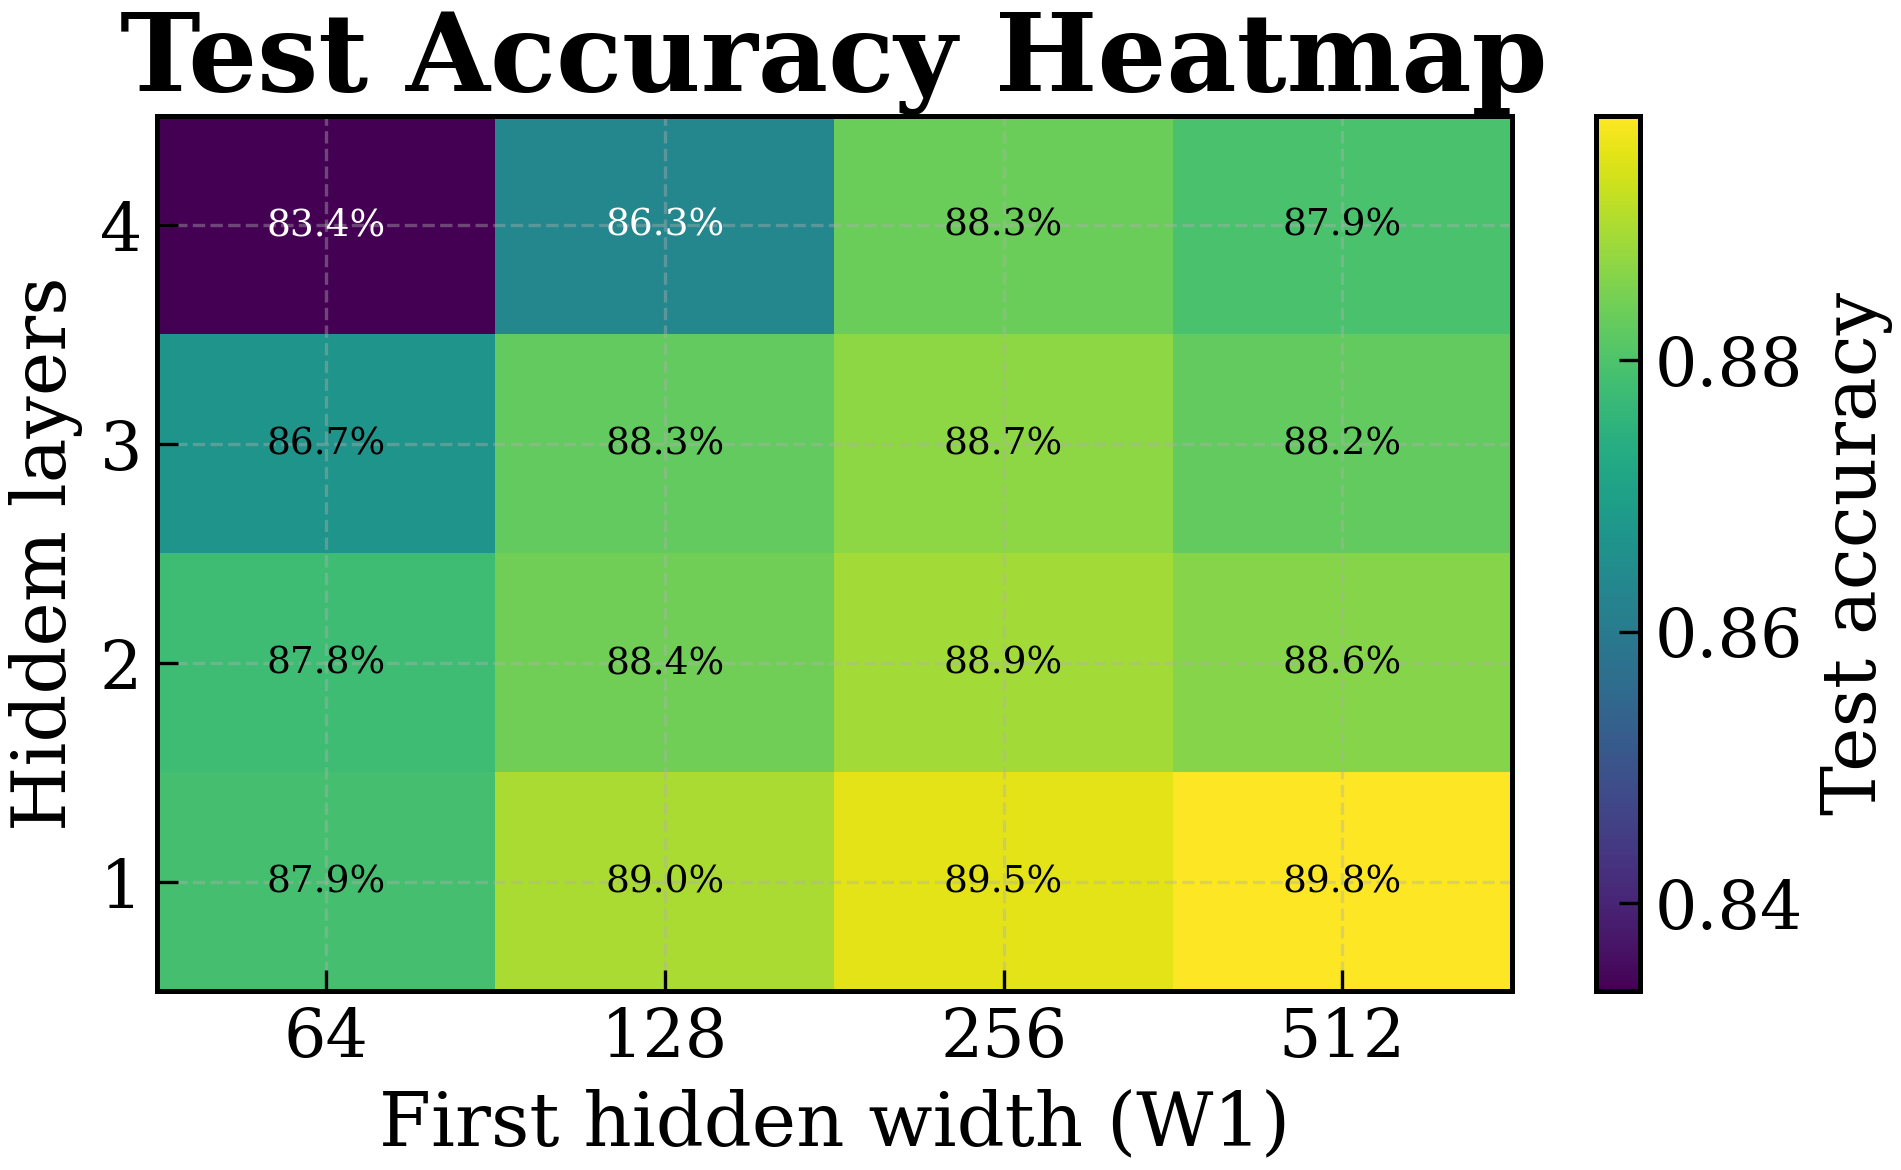

In [38]:
fig, ax = plt.subplots(figsize=(7, 4.5))
im = ax.imshow(H, aspect='auto', origin='lower', vmin=np.min(H), vmax=np.max(H))
ax.set_xticks(np.arange(len(width_list)))
ax.set_yticks(np.arange(len(depth_list)))
ax.set_xticklabels(width_list)
ax.set_yticklabels(depth_list)
ax.set_xlabel("First hidden width (W1)")
ax.set_ylabel("Hiddem layers")
ax.set_title(f"Test Accuracy Heatmap")

# annotate cells
for i in range(len(depth_list)):
    for j in range(len(width_list)):
        ax.text(j, i, f"{H[i,j]*100:.1f}%", ha="center", va="center", fontsize=9, color="white" if H[i,j] < (H.max()+H.min())/2 else "black")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Test accuracy")

plt.tight_layout()
plt.show()

Again, we strongly recommend that you compare your own neural Network
code for classification and pertinent results against a similar code using **Scikit-Learn**  or **tensorflow/keras** or **pytorch**.

If you have time, you can use the functionality of **scikit-learn** and compare your neural network results with those from Logistic regression. This is optional.
The weblink  here <https://medium.com/ai-in-plain-english/comparison-between-logistic-regression-and-neural-networks-in-classifying-digits-dc5e85cd93c3>compares logistic regression and FFNN using the so-called MNIST data set. You may find several useful hints and ideas from this article. Your neural network code can implement the equivalent of logistic regression by simply setting the number of hidden layers to zero and keeping just the input and the output layers. 

If you wish to compare with say Logisti Regression from **scikit-learn**, the following code uses the above data set

In [9]:
from sklearn.linear_model import LogisticRegression
# Initialize the model
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, random_state=42)
# Train the model
model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model Accuracy: 0.8441


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
